In [1]:
import os
import sys
import json
import pysolr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter
from matplotlib.ticker import MaxNLocator

sys.path.append("../helpers/")
from impresso_id import *

data_path = "data"

solr_url = os.environ["SOLR_URL_DEV"]
solr = pysolr.Solr(solr_url + "/impresso_dev")

sns.set()

%load_ext autoreload
%autoreload 2

# All tables

In [2]:
df = pd.read_parquet(os.path.join(data_path, "NLL_lite.parquet"))

## Exploration
The full dataset is first explored to get a general feel and explain some tagging results. The full dataset is also compared to the complete impresso dataset of Luxembourgish newspapers.

In [3]:
print(f"The dataset contains {len(df)} different tables.")
print(f"The dataset contains {len(df['pid'].unique())} different pages.")
print(f"The dataset contains {len(df['meta_issue_id'].unique())} different issues.")

The dataset contains 58011 different tables.
The dataset contains 28497 different pages.
The dataset contains 22735 different issues.


### Year distribution
#### Articles

In [4]:
article_distribution = Counter([get_year(x) for x in df.index.unique()])
article_distribution = pd.DataFrame(article_distribution.values(), article_distribution.keys())
article_distribution = article_distribution.reset_index().rename({"index": "Year", 0: "Count"}, axis=1)
article_distribution = article_distribution.sort_values("Year").reset_index(drop=True)

print(f"Number of tables: {article_distribution['Count'].sum()}")

Number of tables: 58011


In [5]:
results = solr.search("*:*", **{
                      "fl": ["id"],
                      "fq": f"meta_journal_s:({' '.join(df['journal'].unique())})",
                      "group": "true",
                      "group.field": "meta_year_i",
                      "wt": "json",
                      "rows": 300})

In [6]:
article_total_distribution = pd.DataFrame(columns = ['Year', 'Count'])
for result in results.grouped['meta_year_i']['groups']:
    year = result['groupValue']
    count = result['doclist']['numFound']
    article_total_distribution.loc[len(article_total_distribution)] = [year, count]
    
article_total_distribution = article_total_distribution.sort_values(by="Year").reset_index(drop=True)

print(f"Total number of articles: {article_total_distribution['Count'].sum()}")

Total number of articles: 2372990


In [7]:
years = range(article_total_distribution['Year'].min(), article_total_distribution['Year'].max() + 1)
for year in years:
    if year not in set(article_distribution['Year']):
        article_distribution = article_distribution.append({"Year": year, "Count": 0}, ignore_index=True)
        
    if year not in set(article_total_distribution['Year']):
        article_total_distribution = article_total_distribution.append({"Year": year, "Count": 0}, ignore_index=True)
        
article_distribution = article_distribution.sort_values("Year").reset_index(drop=True)
article_total_distribution = article_total_distribution.sort_values("Year").reset_index(drop=True)

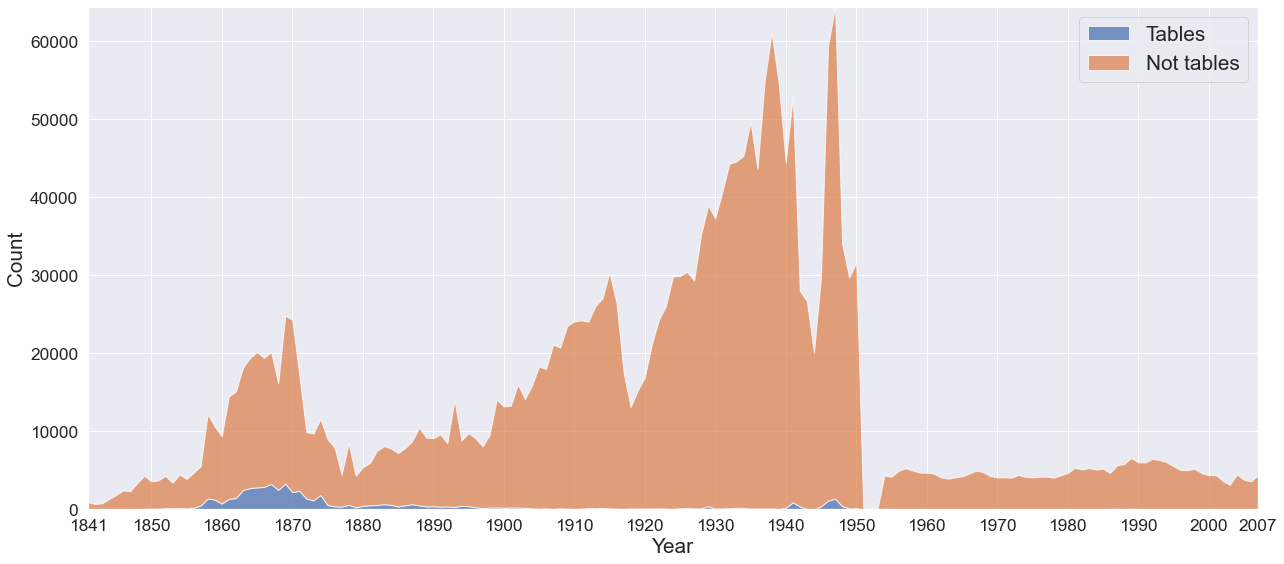

In [8]:
fig, ax = plt.subplots(figsize=(18,8))

bar1 = plt.stackplot(np.array(article_total_distribution['Year']).astype(int),
                     [np.array(article_distribution['Count']), 
                      np.array(article_total_distribution['Count'] - article_distribution['Count']).astype(int)], 
                     labels=["Tables", "Not tables"],
                     alpha=0.75)
                     
years = [article_total_distribution['Year'].iloc[0]] + list(range(1850, 2005, 10)) + [article_total_distribution['Year'].iloc[-1]]
ax.axes.xaxis.set_ticks(years)

ax.margins(x=0, y=0)
ax.tick_params(axis='both', which='major', labelsize='x-large')
plt.xlabel('Year', fontsize='xx-large')
plt.ylabel('Count', fontsize='xx-large')
plt.legend(fontsize='xx-large')
plt.tight_layout()
plt.show()

In [9]:
article_distribution_normalized = pd.merge(article_total_distribution, article_distribution, on='Year', how='outer')
article_distribution_normalized['Percentage'] = article_distribution_normalized.apply(lambda x: x['Count_y']/x['Count_x']*100 if x['Count_x'] != 0 else 0, axis=1)

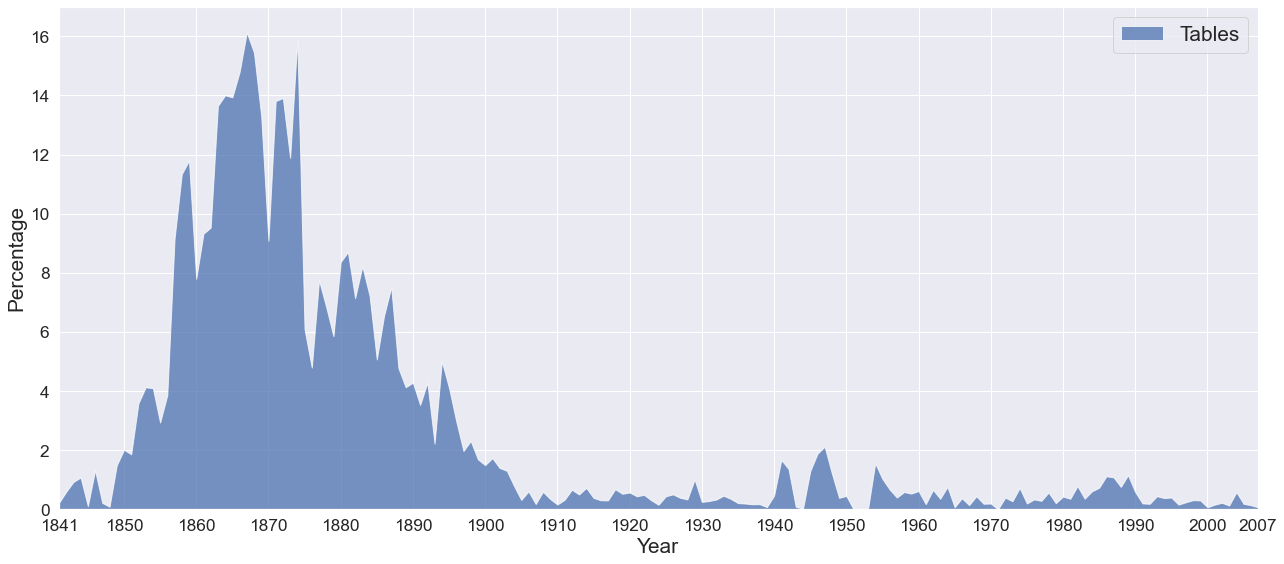

In [10]:
fig, ax = plt.subplots(figsize=(18,8))

bar1 = plt.stackplot(np.array(article_distribution_normalized['Year']).astype(int),
                     [np.array(article_distribution_normalized['Percentage'])],
                     alpha=0.75, labels=['Tables'])
                     
years = [article_total_distribution['Year'].iloc[0]] + list(range(1850, 2005, 10)) + [article_total_distribution['Year'].iloc[-1]]
ax.axes.xaxis.set_ticks(years)

ax.margins(x=0, y=0)
ax.tick_params(axis='both', which='major', labelsize='x-large')
ax.set_ylim([0, 17])
plt.legend(fontsize='xx-large')
plt.xlabel('Year', fontsize='xx-large')
plt.ylabel('Percentage', fontsize='xx-large')
plt.tight_layout()
plt.show()

#### Pages

In [11]:
page_distribution = Counter([get_year(x) for x in df['pid'].unique()])
page_distribution = pd.DataFrame(page_distribution.values(), page_distribution.keys())
page_distribution = page_distribution.reset_index().rename({"index": "Year", 0: "Count"}, axis=1)
page_distribution = page_distribution.sort_values("Year").reset_index(drop=True)

print(f"{page_distribution['Count'].sum()} different pages with tables.")

28497 different pages with tables.


In [12]:
page_total_distribution = {}

start = 1841
end = 2007

for start in np.arange(start, end + 1, 5):
    results = solr.search("*:*", **{
                          "fl": [""],
                          "fq": f"meta_journal_s:({' '.join(df['journal'].unique())}) AND meta_year_i:[{start} TO {start + 5}]",
                          "facet": "true",
                          "facet.pivot": "meta_year_i,page_id_ss",
                          "facet.limit": 1000000,
                          "wt": "json",
                          "rows": 100})
    for x in results.facets['facet_pivot']['meta_year_i,page_id_ss']:
        if x['count'] >= 1000000:
            print(x)
        assert(len(x['pivot']) == len([y['value'] for y in x['pivot']]))
        page_total_distribution[x['value']] = len(x['pivot'])

In [13]:
page_total_distribution = pd.DataFrame(page_total_distribution.values(), page_total_distribution.keys())
page_total_distribution = page_total_distribution.reset_index().rename({"index": "Year", 0: "Count"}, axis=1)
page_total_distribution = page_total_distribution.sort_values("Year").reset_index(drop=True)

print(f"{page_total_distribution['Count'].sum()} different pages.")

352137 different pages.


In [14]:
years = range(page_total_distribution['Year'].min(), page_total_distribution['Year'].max() + 1)
for year in years:
    if year not in set(page_distribution['Year']):
        page_distribution = page_distribution.append({"Year": year, "Count": 0}, ignore_index=True)
        
    if year not in set(page_total_distribution['Year']):
        page_total_distribution = page_total_distribution.append({"Year": year, "Count": 0}, ignore_index=True)
        
page_distribution = page_distribution.sort_values("Year").reset_index(drop=True)
page_total_distribution = page_total_distribution.sort_values("Year").reset_index(drop=True)

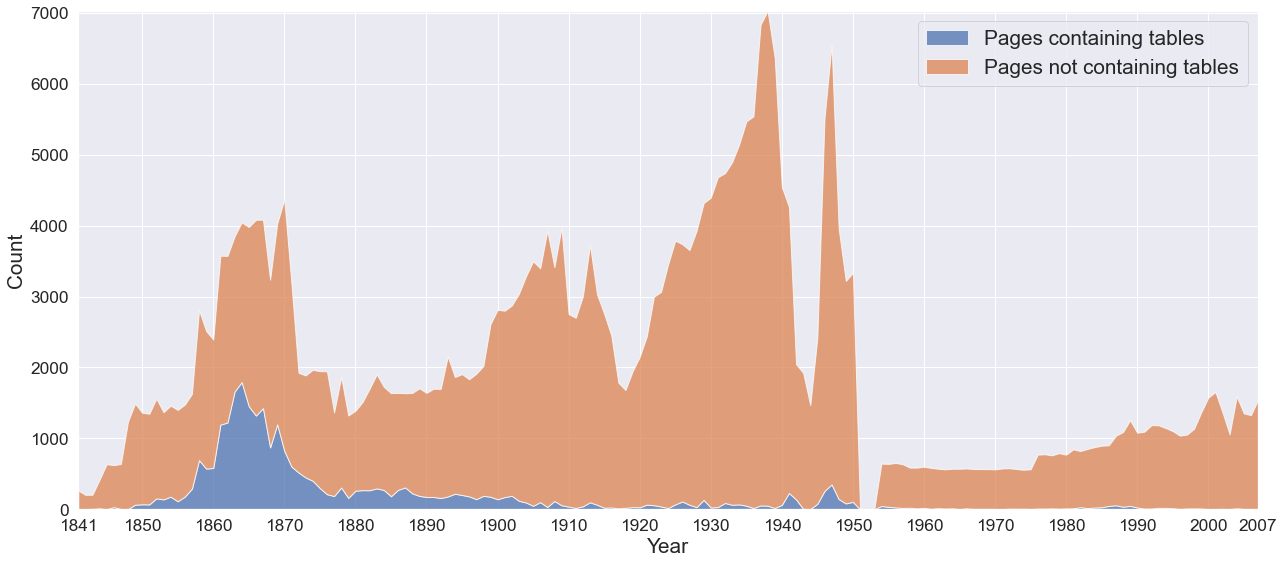

In [15]:
fig, ax = plt.subplots(figsize=(18,8))

bar1 = plt.stackplot(np.array(page_total_distribution['Year']).astype(int),
                     [np.array(page_distribution['Count']), 
                      np.array(page_total_distribution['Count'] - page_distribution['Count']).astype(int)], 
                     labels=["Pages containing tables", "Pages not containing tables"],
                     alpha=0.75)
                     
years = [page_total_distribution['Year'].iloc[0]] + list(range(1850, 2005, 10)) + [page_total_distribution['Year'].iloc[-1]]
ax.axes.xaxis.set_ticks(years)

ax.margins(x=0, y=0)
ax.tick_params(axis='both', which='major', labelsize='x-large')
plt.xlabel('Year', fontsize='xx-large')
plt.ylabel('Count', fontsize='xx-large')
plt.legend(fontsize='xx-large')
plt.tight_layout()
plt.show()

In [16]:
page_distribution_normalized = pd.merge(page_total_distribution, page_distribution, on='Year', how='outer')
page_distribution_normalized['Percentage'] = page_distribution_normalized.apply(lambda x: x['Count_y']/x['Count_x']*100 if x['Count_x'] != 0 else 0, axis=1)

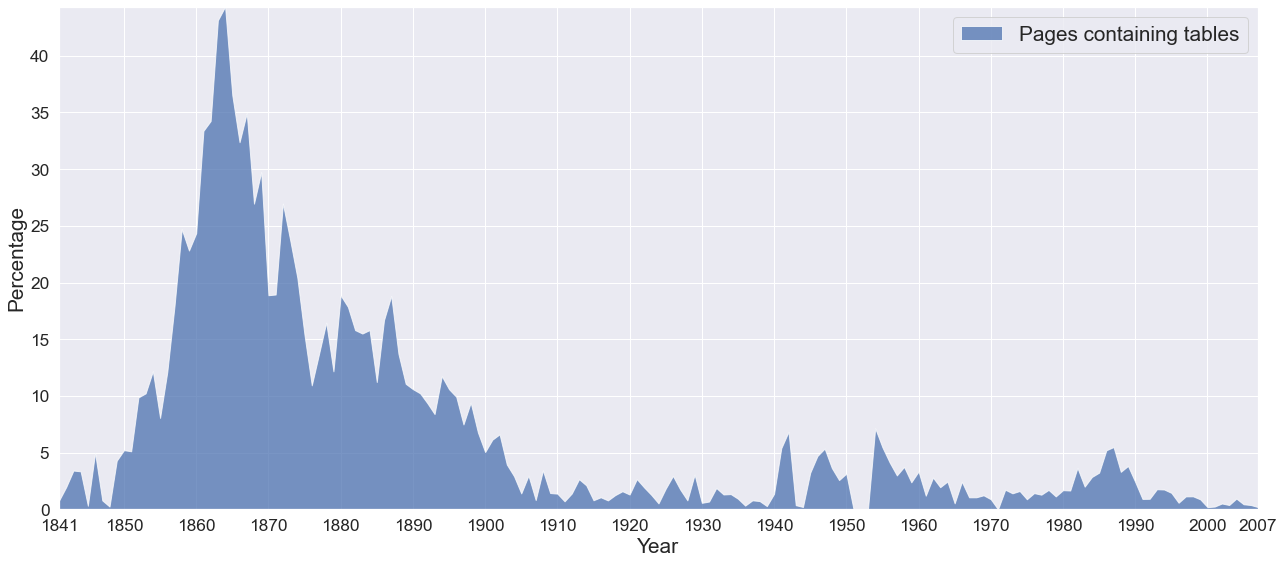

In [17]:
fig, ax = plt.subplots(figsize=(18,8))

bar1 = plt.stackplot(np.array(page_distribution_normalized['Year']).astype(int),
                     [np.array(page_distribution_normalized['Percentage'])],
                     alpha=0.75, labels=['Pages containing tables'])
                     
years = [page_total_distribution['Year'].iloc[0]] + list(range(1850, 2005, 10)) + [page_total_distribution['Year'].iloc[-1]]
ax.axes.xaxis.set_ticks(years)

ax.margins(x=0, y=0)
ax.tick_params(axis='both', which='major', labelsize='x-large')
#ax.set_ylim([0, 100])
plt.xlabel('Year', fontsize='xx-large')
plt.ylabel('Percentage', fontsize='xx-large')
plt.legend(fontsize='xx-large')
plt.tight_layout()
plt.show()

#### Issues

In [18]:
issue_distribution = Counter([get_year(x + '......') for x in df['meta_issue_id'].unique()])
issue_distribution = pd.DataFrame(issue_distribution.values(), issue_distribution.keys())
issue_distribution = issue_distribution.reset_index().rename({"index": "Year", 0: "Count"}, axis=1)
issue_distribution = issue_distribution.sort_values("Year").reset_index(drop=True)

print(f"{issue_distribution['Count'].sum()} different issues with tables.")

22735 different issues with tables.


In [19]:
results = solr.search("*:*", **{
                      "fl": ["meta_issue_id_s"],
                      "fq": f"meta_journal_s:({' '.join(df['journal'].unique())})",
                      "facet": "true",
                      "facet.pivot": "meta_year_i,meta_issue_id_s",
                      "facet.limit": 300000,
                      "wt": "json",
                      "rows": 10000})

In [20]:
issue_total_distribution = {}
for x in results.facets['facet_pivot']['meta_year_i,meta_issue_id_s']:
    assert(sum([y['count'] for y in x['pivot']]) == x['count'])
    issue_total_distribution[x['value']] = len(x['pivot'])
    
issue_total_distribution = pd.DataFrame(issue_total_distribution.values(), issue_total_distribution.keys())
issue_total_distribution = issue_total_distribution.reset_index().rename({"index": "Year", 0: "Count"}, axis=1)
issue_total_distribution = issue_total_distribution.sort_values("Year").reset_index(drop=True)

print(f"{issue_total_distribution['Count'].sum()} different issues.")

65515 different issues.


In [21]:
years = range(issue_total_distribution['Year'].min(), issue_total_distribution['Year'].max() + 1)
for year in years:
    if year not in set(issue_distribution['Year']):
        issue_distribution = issue_distribution.append({"Year": year, "Count": 0}, ignore_index=True)
        
    if year not in set(issue_total_distribution['Year']):
        issue_total_distribution = issue_total_distribution.append({"Year": year, "Count": 0}, ignore_index=True)
        
issue_distribution = issue_distribution.sort_values("Year").reset_index(drop=True)
issue_total_distribution = issue_total_distribution.sort_values("Year").reset_index(drop=True)

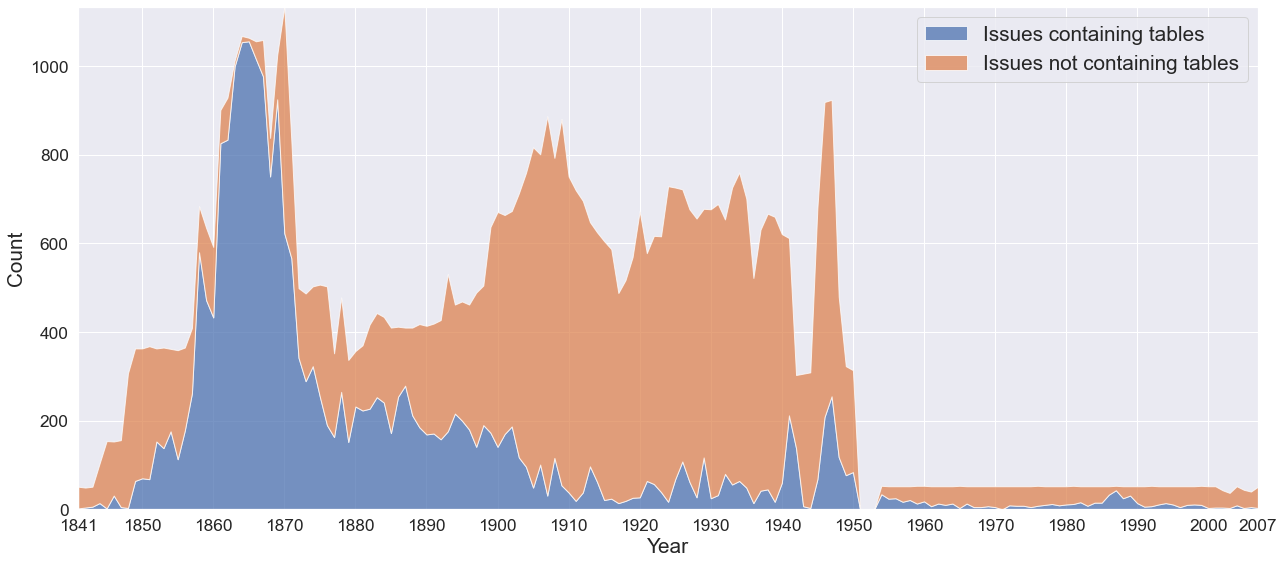

In [22]:
fig, ax = plt.subplots(figsize=(18,8))

bar1 = plt.stackplot(np.array(issue_total_distribution['Year']).astype(int),
                     [np.array(issue_distribution['Count']), 
                      np.array(issue_total_distribution['Count'] - issue_distribution['Count']).astype(int)], 
                     labels=["Issues containing tables", "Issues not containing tables"],
                     alpha=0.75)
                     
years = [issue_total_distribution['Year'].iloc[0]] + list(range(1850, 2005, 10)) + [issue_total_distribution['Year'].iloc[-1]]
ax.axes.xaxis.set_ticks(years)

ax.margins(x=0, y=0)
ax.tick_params(axis='both', which='major', labelsize='x-large')
plt.xlabel('Year', fontsize='xx-large')
plt.ylabel('Count', fontsize='xx-large')
plt.legend(fontsize='xx-large')
plt.tight_layout()
plt.show()

In [23]:
issue_distribution_normalized = pd.merge(issue_total_distribution, issue_distribution, on='Year', how='outer')
issue_distribution_normalized['Percentage'] = issue_distribution_normalized.apply(lambda x: x['Count_y']/x['Count_x']*100 if x['Count_x'] != 0 else 0, axis=1)

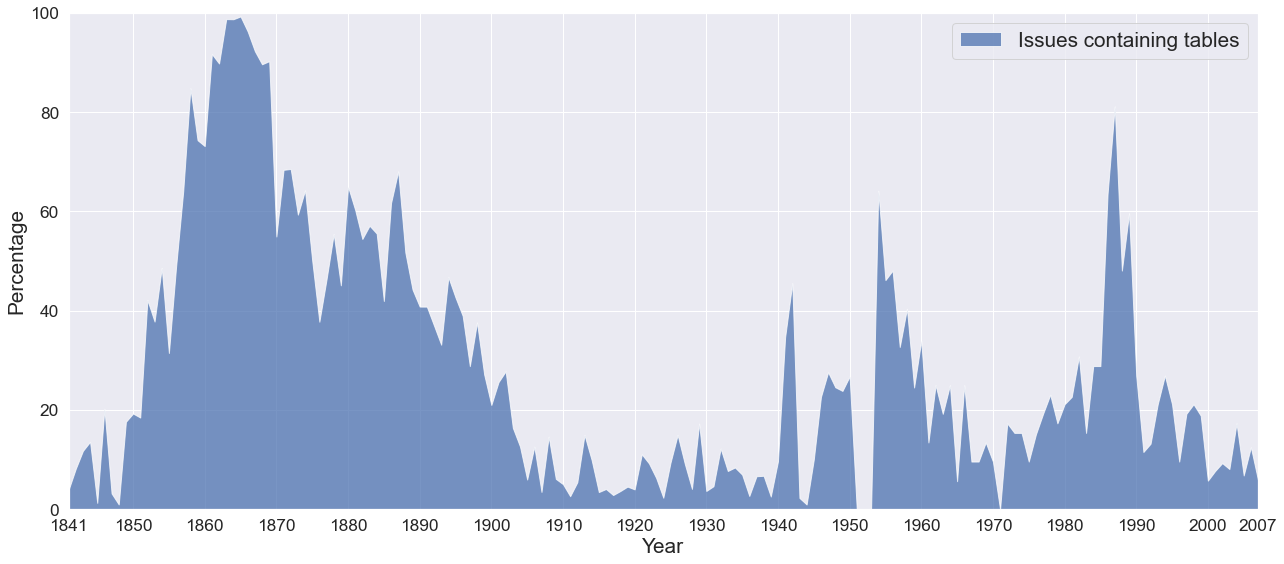

In [24]:
fig, ax = plt.subplots(figsize=(18,8))

bar1 = plt.stackplot(np.array(issue_distribution_normalized['Year']).astype(int),
                     [np.array(issue_distribution_normalized['Percentage'])],
                     alpha=0.75, labels=['Issues containing tables'])
                     
years = [issue_total_distribution['Year'].iloc[0]] + list(range(1850, 2005, 10)) + [issue_total_distribution['Year'].iloc[-1]]
ax.axes.xaxis.set_ticks(years)

ax.margins(x=0, y=0)
ax.tick_params(axis='both', which='major', labelsize='x-large')
ax.set_ylim([0, 100])
plt.xlabel('Year', fontsize='xx-large')
plt.ylabel('Percentage', fontsize='xx-large')
plt.legend(fontsize='xx-large')
plt.tight_layout()
plt.show()

#### Journal distribution

In [25]:
articles_per_journal = df.groupby("journal").count()["pid"].sort_index(ascending=False)
articles_per_journal = articles_per_journal.reset_index().rename({"journal": "Journal", 'pid': "Count"}, axis=1)
articles_per_journal = articles_per_journal.sort_values("Journal").reset_index(drop=True)

In [26]:
results = solr.search("*:*", **{
                      "fl": ["meta_journal_s"],
                      "fq": f"meta_journal_s:({' '.join(df['journal'].unique())})",
                      "group": "true",
                      "group.field": "meta_journal_s",
                      "wt":"json",
                      "rows": 10000})

In [27]:
articles_per_journal_total = {x["groupValue"]: x["doclist"]["numFound" ]for x in results.grouped["meta_journal_s"]["groups"]}
articles_per_journal_total = pd.DataFrame(articles_per_journal_total.values(), articles_per_journal_total.keys())
articles_per_journal_total = articles_per_journal_total.reset_index().rename({"index": "Journal", 0: "Count"}, axis=1)
articles_per_journal_total = articles_per_journal_total.sort_values("Journal").reset_index(drop=True)

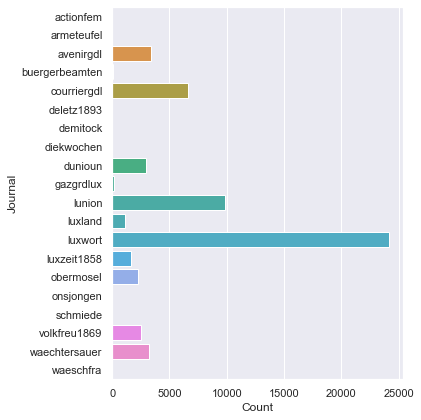

In [28]:
fig, ax = plt.subplots(figsize=(6, 6))
bar2 = sns.barplot(x="Count", y="Journal", data=articles_per_journal)

plt.tight_layout()
plt.show()

In [29]:
articles_per_journal_normalized = pd.merge(articles_per_journal_total, articles_per_journal, on='Journal', how='outer')
articles_per_journal_normalized['Percentage'] = articles_per_journal_normalized.apply(lambda x: x['Count_y']/x['Count_x']*100 if x['Count_x'] != 0 else 0, axis=1)

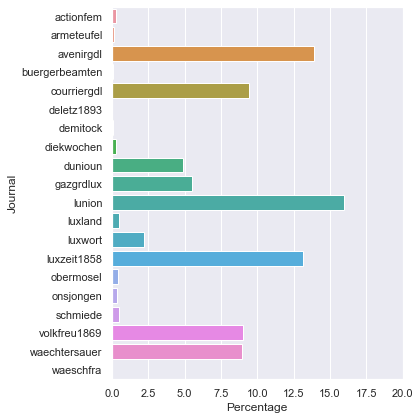

In [30]:
fig, ax = plt.subplots(figsize=(6, 6))

sns.barplot(x='Percentage', y='Journal', data=articles_per_journal_normalized)

ax.set_xlim([0, 20])
ax.set_xlabel("Percentage")
plt.tight_layout()
plt.show()

In [31]:
pages_per_journal = Counter([get_journal(x) for x in df['pid'].unique()])
pages_per_journal = pd.DataFrame(pages_per_journal.values(), pages_per_journal.keys())
pages_per_journal = pages_per_journal.reset_index().rename({"index": "Journal", 0: "Count"}, axis=1)
pages_per_journal = pages_per_journal.sort_values("Journal").reset_index(drop=True)

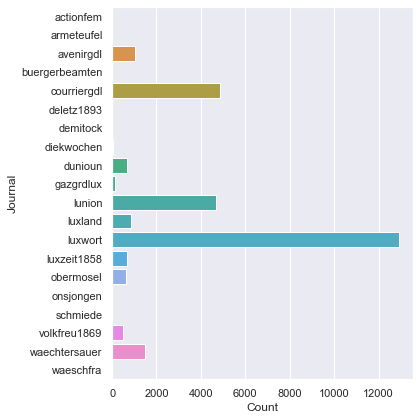

In [32]:
fig, ax = plt.subplots(figsize=(6, 6))
bar2 = sns.barplot(x="Count", y="Journal", data=pages_per_journal)

plt.tight_layout()
plt.show()

In [33]:
pages_per_journal_total = {}

start = 1841
end = 2007

for start in np.arange(start, end + 1, 5):
    results = solr.search("*:*", **{
                          "fl": [""],
                          #"fq": "meta_partnerid_s:BNL",
                          "fq": f"meta_journal_s:({' '.join(df['journal'].unique())}) AND meta_year_i:[{start} TO {start + 5}]",
                          "facet": "true",
                          "facet.pivot": "meta_journal_s,page_id_ss",
                          "facet.limit": 1000000,
                          "wt": "json",
                          "rows": 100})

    for x in results.facets['facet_pivot']['meta_journal_s,page_id_ss']:
        if x['count'] >= 1000000:
            print(x)
        assert(len(x['pivot']) == len(set(y['value'] for y in x['pivot'])))
        if x['value'] not in pages_per_journal_total:
            pages_per_journal_total[x['value']] = 0
        pages_per_journal_total[x['value']] += len(x['pivot'])

In [34]:
pages_per_journal_total = pd.DataFrame(pages_per_journal_total.values(), pages_per_journal_total.keys())
pages_per_journal_total = pages_per_journal_total.reset_index().rename({"index": "Journal", 0: "Count"}, axis=1)
pages_per_journal_total = pages_per_journal_total.sort_values("Journal").reset_index(drop=True)

In [35]:
pages_per_journal_normalized = pd.merge(pages_per_journal_total, pages_per_journal, on='Journal', how='outer')
pages_per_journal_normalized['Percentage'] = pages_per_journal_normalized.apply(lambda x: x['Count_y']/x['Count_x']*100 if x['Count_x'] != 0 else 0, axis=1)

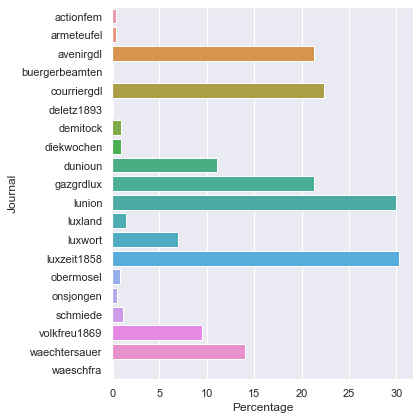

In [36]:
fig, ax = plt.subplots(figsize=(6, 6))
bar2 = sns.barplot(x="Percentage", y="Journal", data=pages_per_journal_normalized)

plt.tight_layout()
plt.show()

### Table area

This part of the code necessits a file containing the sizes of the images of newspaper pages to correctly function. This file is automatically generated when downloading images using *download_images_from_s3.py*.

In [38]:
with open("NLL_metadata_images.json", "r") as f:
    metadata = json.load(f)

In [39]:
df['area_normalized'] = df.apply(lambda x: 100*x['area']/(metadata[x['pid']]['height']*metadata[x['pid']]['width']) if x['pid'] in metadata else 0, axis=1)
df['resolution'] = df.apply(lambda x: (metadata[x['pid']]['height']*metadata[x['pid']]['width']) if x['pid'] in metadata else 0, axis=1)

In [40]:
area_distribution = df.groupby("year").sum()["area_normalized"].sort_index(ascending=False)
area_distribution = area_distribution.reset_index().rename({"year": "Year", 'area_normalized': "Area (normalized)"}, axis=1)
area_distribution = area_distribution.sort_values("Year").reset_index(drop=True)

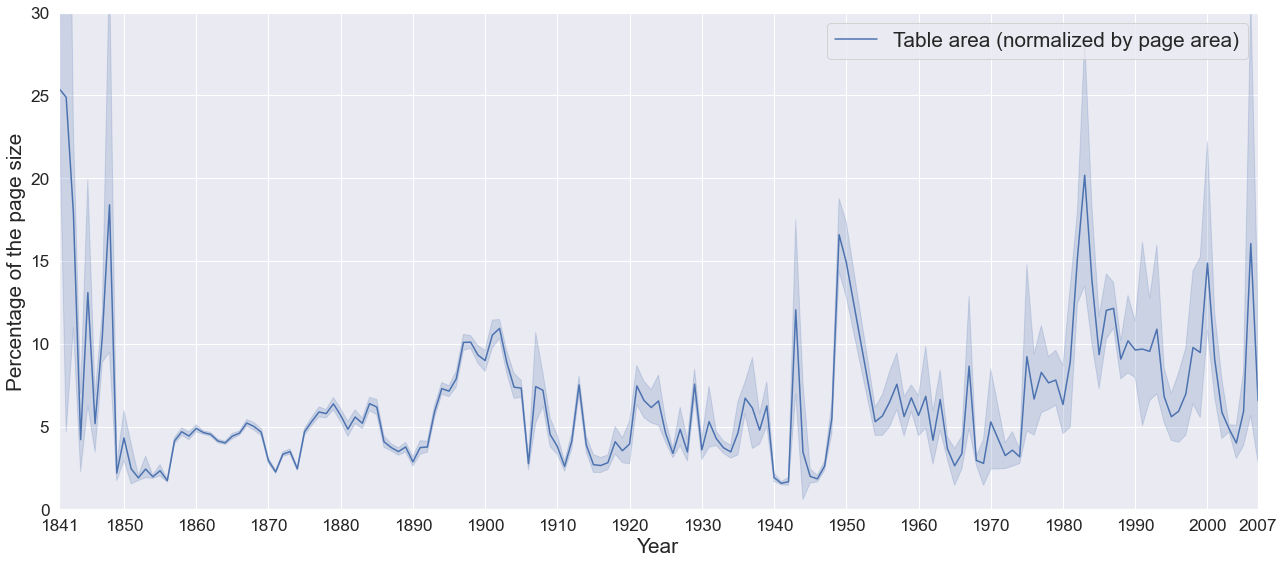

In [41]:
fig, ax = plt.subplots(figsize=(18, 8))

sns.lineplot(x='year', y='area_normalized', data=df, label='Table area (normalized by page area)')

years = [area_distribution['Year'].iloc[0]] + list(range(1850, 2005, 10)) + [area_distribution['Year'].iloc[-1]]
ax.axes.xaxis.set_ticks(years)

ax.margins(x=0, y=0)
ax.tick_params(axis='both', which='major', labelsize='x-large')
plt.ylim([0,30])
plt.xlabel('Year', fontsize='xx-large')
plt.ylabel('Percentage of the page size', fontsize='xx-large')
plt.legend(fontsize='xx-large')
plt.tight_layout()
plt.show()

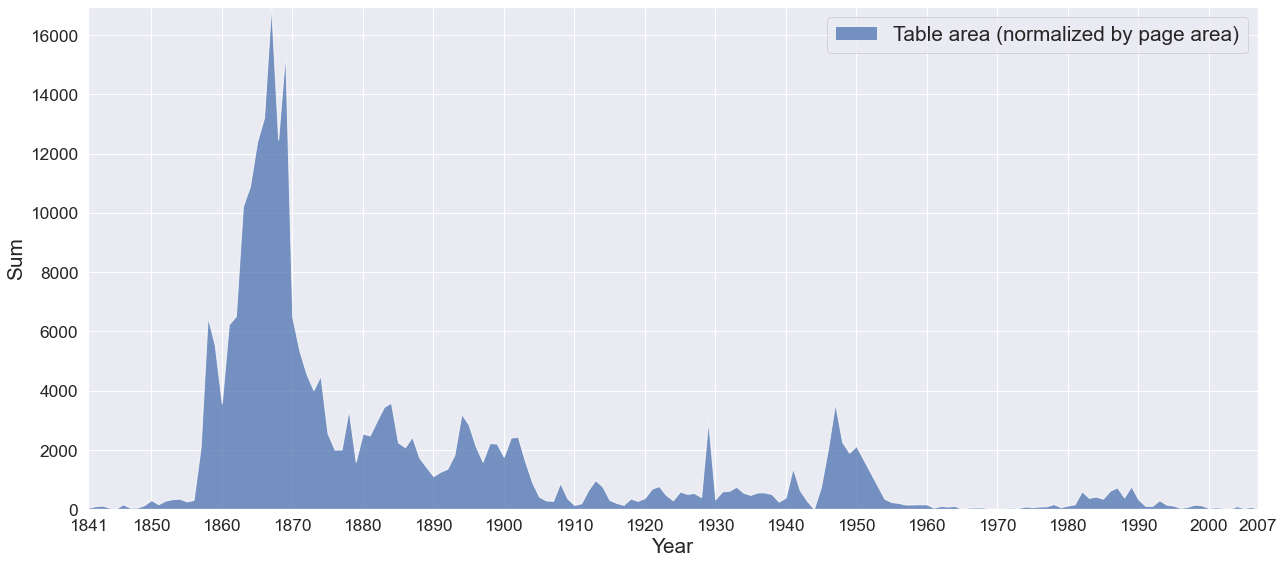

In [42]:
fig, ax = plt.subplots(figsize=(18, 8))

bar1 = plt.stackplot(np.array(area_distribution['Year']).astype(int),
                     [np.array(area_distribution['Area (normalized)'])],
                     alpha=0.75, labels=['Table area (normalized by page area)'])

years = [area_distribution['Year'].iloc[0]] + list(range(1850, 2005, 10)) + [area_distribution['Year'].iloc[-1]]
ax.axes.xaxis.set_ticks(years)

ax.tick_params(axis='both', which='major', labelsize='x-large')
ax.margins(x=0, y=0)
plt.xlabel('Year', fontsize='xx-large')
plt.ylabel('Sum', fontsize='xx-large')
plt.legend(fontsize='xx-large')
plt.tight_layout()
plt.show()

In [43]:
resolution_distribution = df.groupby("year").mean()["resolution"].sort_index(ascending=False)
resolution_distribution = resolution_distribution.reset_index().rename({"year": "Year", 'resolution': "Resolution"}, axis=1)
resolution_distribution = resolution_distribution.sort_values("Year").reset_index(drop=True)

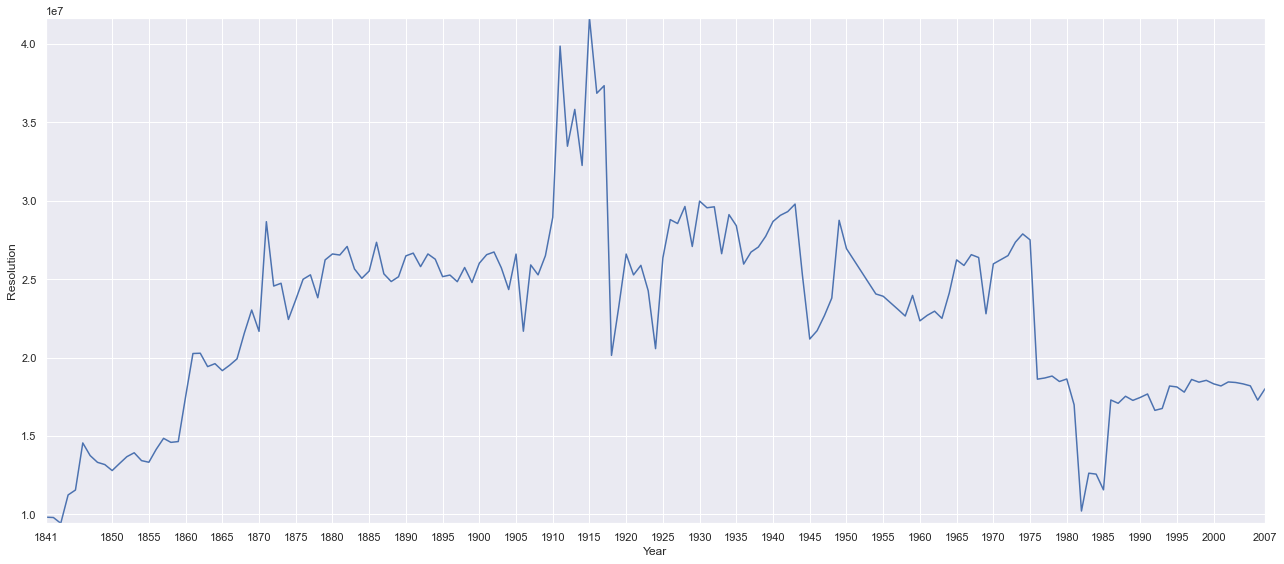

In [44]:
fig, ax = plt.subplots(figsize=(18, 8))

sns.lineplot(x='Year', y='Resolution', data=resolution_distribution)

years = [resolution_distribution['Year'].iloc[0]] + list(range(1850, 2005, 5)) + [resolution_distribution['Year'].iloc[-1]]
ax.axes.xaxis.set_ticks(years)

ax.margins(x=0, y=0)
plt.tight_layout()
plt.show()